### Aplicando método de otimização para ajuste do modelo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler 

In [2]:
#import data
data = pd.read_csv("Datasets/sjc.csv")  
city_name = 'São José dos Campos'
acc_n_cases = data.total_confirmed
normalized_acc_n_cases = data.total_confirmed / max(data.total_confirmed)
t = np.linspace(0, len(acc_n_cases), len(acc_n_cases))

# for the "one wave" tests
model = f_t
n_days = 90 

110228 1053322 154715


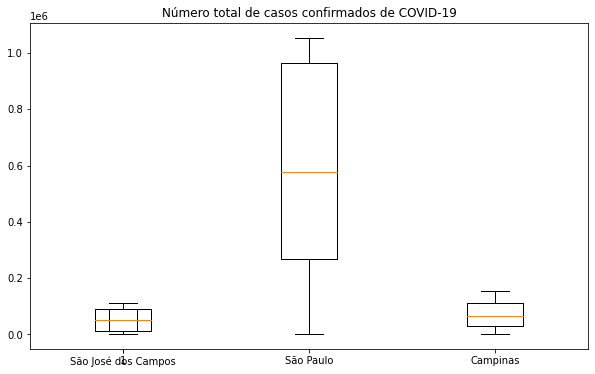

In [3]:
plt.figure(figsize=(10,6))
plt.title('Número total de casos confirmados de COVID-19')
plt.boxplot(acc_n_cases)
data = pd.read_csv("Datasets/sp.csv")  
sp = data.total_confirmed
data = pd.read_csv("Datasets/campinas.csv")  
camp = data.total_confirmed
plt.boxplot([acc_n_cases, sp, camp],labels=[f'São José dos Campos', 'São Paulo', 'Campinas'])
print(np.max(acc_n_cases), np.max(sp), np.max(camp))

plt.show()

### 1 - Uma onda epidemiológica

#### 1.1 - Definindo o problema de otimização
Definiremos uma função para descrever a perda do modelo em relação aos dados reais. Ela será a função objetivo do problema de minimização.

Seja o vetor x de parâmetros:
$$x = [A\quad \nu\quad \delta\quad t_p]^T$$
Problema de otimização descrito no artigo da ASOC:
$$min \sum_{t=0}^{t=t_{end}} t(y_t(t) - y_m(t, x))^2$$ 

$$\textrm{s.t.}\quad A \geq 0,\\\quad\quad\ \nu > 0,\\\quad\quad\ \delta > 0,\\\quad\quad\  t_p \geq 0$$ 

Ao invés de utilizarmos a função objetivo apresentada (ITSE), _utilizaremos a Mean Squared Error_ (MSE), que pode ser formulada da seguinte forma:
$$MSE(x) = \sum_{t=0}^{t=t_{end}} (y_t(t) - y_m(t, x))^2$$

A otimização será feita em duas etapas:
- 1 - Otimizar uma sigmoide simétrica ($\nu$ = 1)
- 2 - Otimizar uma sigmoide assimétrica, utilizando o ponto ótimo da etapa 1 como ponto inicial.

Para a implementação, estamos utilizando a função [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
) do pacote do otimização da biblioteca Scipy. O método de otimização utilizado é o _Sequential Least Squares Programming_ (SLSQP).

![](https://i.imgur.com/4goNTaQ.png)

A função em questão também permite a utilização de diversos outros métodos de otimização.

![](https://i.imgur.com/m2hO3lL.png)



In [4]:
n_sig = 1
sig_params = []
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

def model_daily(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += deriv_f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += deriv_f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_cases[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_cases[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta = 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 350.82923775296564
     jac: array([-1.52587891e-05,  9.53674316e-05, -5.60760498e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 211
     nit: 38
    njev: 37
  status: 0
 success: True
       x: array([1.77136502e+03, 9.83892706e+01, 1.64246144e+01, 1.00000000e+00])


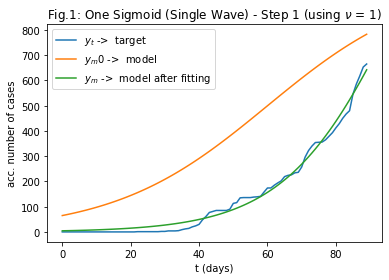

In [5]:
# Step 1 - Optimize a symmetric sigmoid (nu = 1)
y_t = acc_n_cases[:n_days]
A0 = 1.5*max(y_t)
tp0 = (2/3)*len(y_t)
delta0 = (1/4)*len(y_t)
nu0 = 1
x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.1: One Sigmoid (Single Wave) - Step 1 (using $\\nu$ = 1)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

     fun: 291.7314411783928
     jac: array([-1.41143799e-04,  6.17866516e-02, -7.28797913e-02,  7.69738770e+01])
 message: 'Optimization terminated successfully'
    nfev: 510
     nit: 95
    njev: 95
  status: 0
 success: True
       x: array([9.96406090e+03, 1.58519033e+02, 6.03229364e+01, 1.00000000e-01])


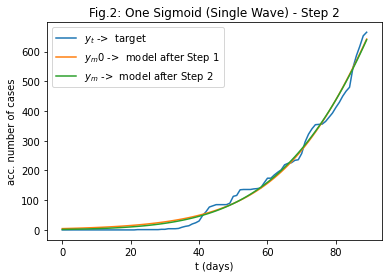

In [6]:
# Step 2 - Optimize an assymmetric sigmoid
# using optimal values of step 1 as the starting point
[A0, tp0, delta0, nu0] = sol.x

x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_t = acc_n_cases[:n_days]
y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.2: One Sigmoid (Single Wave) - Step 2')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
plt.plot(y_m, label='$y_m$ ->  model after Step 2')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

### 2 - Múltiplas ondas epidemiológicas
Para fazer o ajuste do modelo para dados de N ondas epidemiológicas, utilizamos um modelo que envolve a soma de N sigmoides ($f(t)$).

![](https://i.imgur.com/YixfYwH.png)

In [7]:
a = []
a.append([1, 2, 3, 4])
a.append([5, 6, 7, 8])
print(a)
print(a[0])

[[1, 2, 3, 4], [5, 6, 7, 8]]
[1, 2, 3, 4]


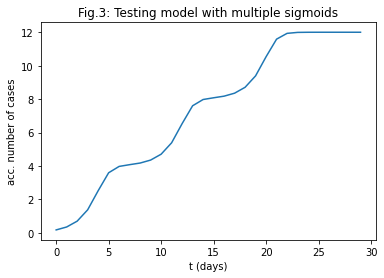

In [8]:
# Testing model for multiple sigmoids
n_days = 30
n_sig = 3
sig_params = [
    [4, 4, 0.5, 2.9],
    [4, 12, 0.5, 2.9]
]
[A, tp, delta, nu] = [4, 20, 0.5, 2.9]
plt.title('Fig.3: Testing model with multiple sigmoids')
plt.plot(model(t[:n_days], A, tp, delta, nu))
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.show()

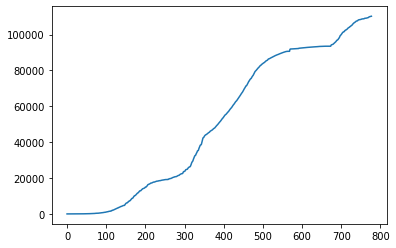

In [9]:
plt.plot(acc_n_cases)

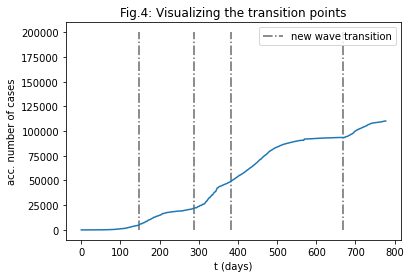

In [10]:
fig = plt.figure()
plt.plot(acc_n_cases)
# Defini manualmente, por enquanto...
# pelo new_wave.py daria x_t [11, 101, 167, 254] (Jerusalem)
# x_nw = [90, 170, 240] #(Jerusalém)
x_nw = [147, 287, 382, 669] #(SJC)
#x_nw = [79, 254, 309, 370, 683] # (SP)
#x_nw  = [94, 146, 269, 314, 377, 469, 607, 677, 741] # Campinas tr 2e-5
#x_nw = [100, 149, 471, 610, 681, 741] # Campinas tr 3e-5
plt.title('Fig.4: Visualizing the transition points')
plt.vlines(x_nw, 0, 200e3, colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()


========= Wave nr 1 =========
From 0 to  147
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1676.608323616817
     jac: array([-0.00018311,  0.02165222, -0.02243042,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 242
     nit: 40
    njev: 40
  status: 0
 success: True
       x: array([7.74281021e+03, 1.35747598e+02, 1.92319448e+01, 1.00000000e+00])
Step 2
     fun: 1162.2581193146796
     jac: array([ 9.15527344e-05, -3.03649902e-03,  3.15246582e-02,  9.74121094e-02])
 message: 'Optimization terminated successfully'
    nfev: 250
     nit: 44
    njev: 44
  status: 0
 success: True
       x: array([5.69687489e+03, 1.30168432e+02, 1.01990143e+01, 2.19198067e+00])


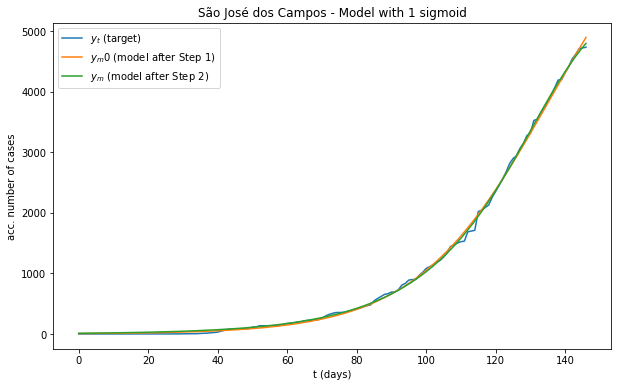

========= Wave nr 2 =========
From 0 to  287
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 187758.2600918629
     jac: array([ 0.        , -0.04492188, -0.01953125,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 428
     nit: 72
    njev: 71
  status: 0
 success: True
       x: array([1.42967935e+04, 1.89432042e+02, 1.73612768e+01, 1.00000000e+00])
Step 2
     fun: 75640.0774464853
     jac: array([ 6.64062500e-02,  8.42675781e+00, -4.25878906e+00,  9.61274561e+04])
 message: 'Positive directional derivative for linesearch'
    nfev: 74
     nit: 16
    njev: 12
  status: 8
 success: False
       x: array([1.49212691e+04, 1.80818193e+02, 2.67240165e+01, 9.99862111e-02])


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


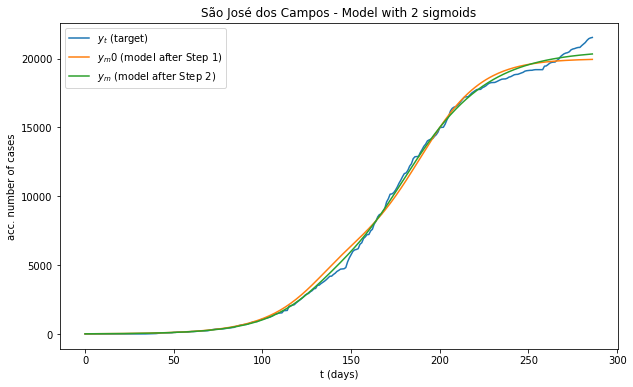

========= Wave nr 3 =========
From 0 to  382
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 85488.38768970076
     jac: array([ 0.00683594,  0.79980469, -0.4921875 ,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 210
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([2.86806968e+04, 3.33010240e+02, 1.50399620e+01, 1.00000000e+00])
Step 2
     fun: 84974.03753196966
     jac: array([-0.00195312,  0.05175781, -0.05175781, -0.6640625 ])
 message: 'Optimization terminated successfully'
    nfev: 87
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([2.89204641e+04, 3.32613489e+02, 1.57933854e+01, 9.03479216e-01])


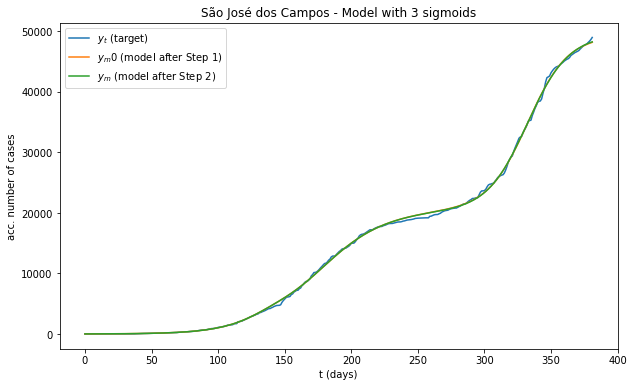

========= Wave nr 4 =========
From 0 to  669
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 486186.7351807651
     jac: array([ 0.01171875,  2.6484375 , -3.76953125,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 167
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([4.31154224e+04, 4.58585433e+02, 2.94215157e+01, 1.00000000e+00])
Step 2
     fun: 486186.7351807651
     jac: array([-7.81250000e-03,  2.68359375e+00, -3.76171875e+00,  6.36542414e+05])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 5
    njev: 1
  status: 0
 success: True
       x: array([4.31154224e+04, 4.58585433e+02, 2.94215157e+01, 1.00000000e+00])


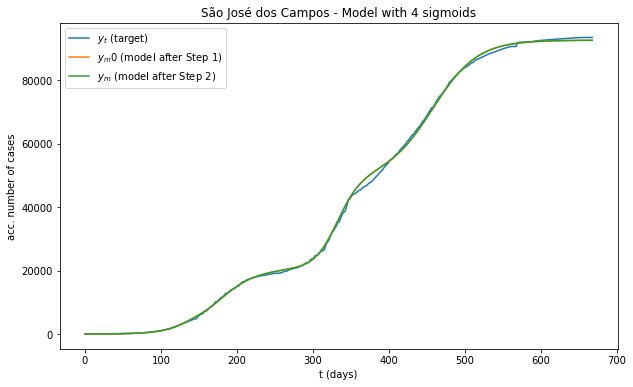

========= Wave nr 5 =========
From 0 to  778
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 414386.56049368693
     jac: array([0.01171875, 0.015625  , 0.0078125 , 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 140
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([1.72059583e+04, 7.08546382e+02, 1.67726873e+01, 1.00000000e+00])
Step 2
     fun: 411444.70722103945
     jac: array([-0.01171875, -0.296875  , -0.1171875 ,  4.7265625 ])
 message: 'Optimization terminated successfully'
    nfev: 112
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([1.75946762e+04, 7.05497902e+02, 2.02587472e+01, 5.66542550e-01])


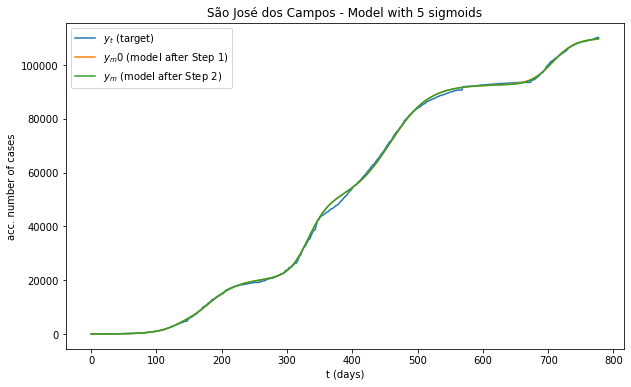

In [11]:
n_sig = 1
sig_params = []
for i in range(len(x_nw) + 1):
    if(i == len(x_nw)):
        n_days = len(acc_n_cases)
    else:
        n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_n_cases[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 70
        A0 *= 0.05
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    y_t = acc_n_cases[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.figure(figsize=(10,6))
    plt.title(f'{city_name} - Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ (target)')
    plt.plot(y_m0, label='$y_m0$ (model after Step 1)')
    plt.plot(y_m, label='$y_m$ (model after Step 2)')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of cases')
    plt.legend()
    #plt.savefig(f'output/{i:003}', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

<Figure size 720x432 with 0 Axes>

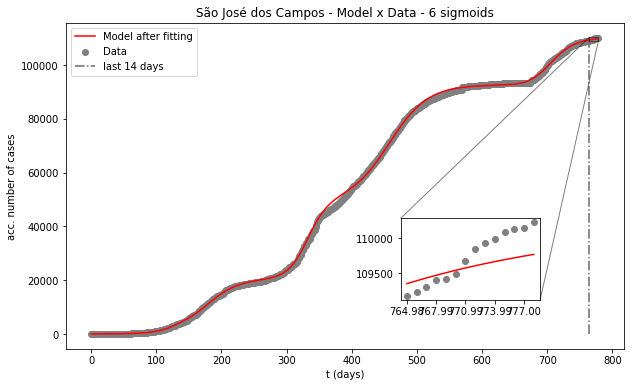

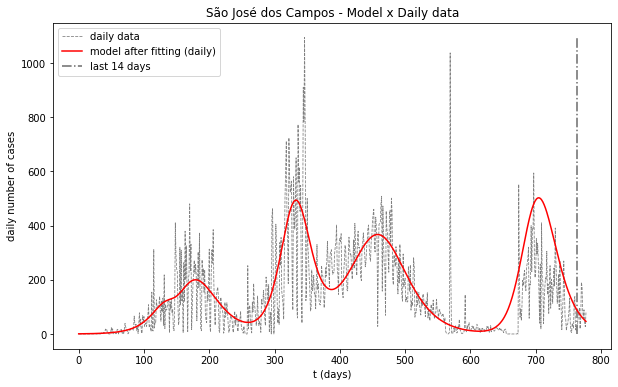

In [13]:
n_sig = 6

n_weeks_pred = 2
y_t = acc_n_cases[:n_days]
y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
daily_n_cases = forward_euler(t[:n_days], 1, acc_n_cases[:n_days], 0)
s = "" if (n_sig == 1) else "s"

# Plotting Model vs Data
plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=[10,6])
#plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
ax.set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
ax.scatter(t[:n_days], acc_n_cases[:n_days], label='Data', c='gray')
ax.vlines(n_days - 7*n_weeks_pred, 0, max(acc_n_cases[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
ax.plot(y_m, label='Model after fitting', c='r')
ax.set_xlabel('t (days)')
ax.set_ylabel('acc. number of cases')
ax.legend()
X_detail = t[n_days - 7*n_weeks_pred: n_days]
Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
#detail prediction
if(n_sig < 3):
    sub_axes = ax.inset_axes([.17, .45, .25, .35]) 
else:
    sub_axes = ax.inset_axes([.6, .15, .25, .25]) 
sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_n_cases[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
sub_axes.plot(X_detail, Y_detail, c = 'r') 
sub_axes.set_xticks(X_detail[0::3])
ax.indicate_inset_zoom(sub_axes, edgecolor="black")    
plt.savefig(f'output/005.png', facecolor='white', dpi=100)
plt.show()

# DAILY DATA
plt.figure(figsize=(10, 6))

plt.title(f'{city_name} - Model x Daily data')
plt.plot(daily_n_cases[:n_days], label="daily data", c='gray', lw=0.8, linestyle='dashed')
plt.plot(y_m_daily, label='model after fitting (daily)', c='r')
plt.vlines(n_days - 7*n_weeks_pred, 0, max(daily_n_cases[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
plt.xlabel('t (days)')
plt.ylabel('daily number of cases')
plt.legend(loc=2) # upper left
plt.savefig(f'output/Daily_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
plt.show()

In [ ]:
n_days

In [ ]:
model_der = forward_euler(t[:n_days], 1, y_m[:n_days], 0)
daily_n_cases = forward_euler(t[:n_days], 1, acc_n_cases[:n_days], 0)

plt.figure(figsize=(8, 5))
plt.title('Fig.6: Model derivative x Actual data')
plt.plot(daily_n_cases, label="unfiltered data", c='silver', linestyle='dashed')
plt.plot(filter_data(daily_n_cases), label="filtered data")
plt.plot(model_der, label='model after fitting (derivative)')
plt.xlabel('t (days)')
plt.ylabel('daily number of cases')
plt.legend()
plt.show()

#### ===== Rascunho (testes para melhor entendimento) =====

In [ ]:
n_sig = 1
n_days = 90
# Initialize model parameters
A = 1500
tp = 20
delta = 3.1
nu = 2.2

y_t = acc_n_cases[:n_days]
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m, label='$y_m$ ->  model')
plt.plot(y_t - y_m, label='$y_t - y_m$')
plt.plot(abs(y_t - y_m), label='|$y_t - y_m$|')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()
plt.title('Squared Error')
plt.plot((y_t - y_m)**2, label='$(y_t - y_m)^2$')
plt.legend()
plt.show()
plt.title('Time Squared Error')
plt.plot(t[:n_days]*(y_t - y_m)**2, label='$t(y_t - y_m)^2$')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()


In [ ]:
# Fazendo testes com múltiplas ondas
# Modelo envolvendo soma de sigmoides assimétricas 
n_sig = 4
x = np.random.rand(4*n_sig)
x

In [ ]:
# Antigo... ignorar
n_sig = 4
# inicialização aleatória
x = np.random.rand(4*n_sig)
sigsum = np.zeros(n_days)
for i in range(n_sig):
    A = 1e2*x[i + 0]
    tp = 8*(i+1)
    delta = 2*x[i + 2]
    nu = 1
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
plt.plot(sigsum)
plt.show()

In [ ]:
acc_data = acc_n_cases
daily_data = daily_n_cases
n_weeks_pred = 2
n_sig = 1
sig_params = []

for i in range(len(x_nw)):
    #x_nw[i]
    n_days = x_nw[i] 
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 70
        A0 *= 0.05

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # prediction interval
    n_days = x_nw[i] + 7*n_weeks_pred

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    # Plotting Model vs Data

    fig, axs = plt.subplots(1, 2, figsize=[15,5])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    axs[0].set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
    axs[0].scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    axs[0].vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[0].plot(y_m, label='Model', c='r')
    axs[0].set_xlabel('t (days)')
    axs[0].set_ylabel('acc. number of cases')
    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
    # detail prediction
    if(n_sig < 3):
        sub_axes = axs[0].inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = axs[0].inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    axs[0].indicate_inset_zoom(sub_axes, edgecolor="black")    
    #plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)


    # Plotting Daily Data

    axs[1].set_title(f'{city_name} - Model x Daily data')
    axs[1].plot(daily_data[:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[1].plot(y_m_daily, label='Model', c='r')
    axs[1].vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[1].set_xlabel('t (days)')
    axs[1].set_ylabel('daily number of cases')
    axs[1].legend(loc=2) # upper left
    plt.savefig(f'ESTADOSP/ACC_DAILY_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'Parameters: {sig_params}\n==================================')    

plt.tight_layout()
#plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()
